In [1]:
import os
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms, models
from torch.utils.data import DataLoader
from setting.setting import *
import matplotlib.pyplot as plt

C:\Users\ntrantrong\AppData\Local\Programs\Python\Python39\lib\site-packages\torch\utils\_pytree.py:185: FutureWarning: optree is installed but the version is too old to support PyTorch Dynamo in C++ pytree. C++ pytree support is disabled. Please consider upgrading optree using `python3 -m pip install --upgrade 'optree>=0.13.0'`.
  warnings.warn(


In [2]:
data_dir = "../../dataset/processed/v1/training"
val_data_dir = "../../dataset/processed/v1/validation"
model_dir = "../../models/MobileNetV2"
best_model_filename = 'mobilenetv2_best_model_v1.pth'
os.makedirs(model_dir, exist_ok=True)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [3]:
data_transforms = {
    'train': transforms.Compose([
        transforms.RandomHorizontalFlip(),
        transforms.RandomRotation(10),
        transforms.RandomResizedCrop((IMG_HEIGHT, IMG_WIDTH), scale=(0.9, 1.0)),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize((IMG_HEIGHT, IMG_WIDTH)),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

train_dataset = datasets.ImageFolder(root=data_dir, transform=data_transforms['train'])
val_dataset = datasets.ImageFolder(root=val_data_dir, transform=data_transforms['val'])

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=4)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=4)

In [4]:
base_model = models.mobilenet_v2(pretrained=True)
for param in base_model.parameters():
    param.requires_grad = False
base_model.classifier[1] = nn.Linear(base_model.classifier[1].in_features, 26)
model = base_model.to(device)

C:\Users\ntrantrong\AppData\Local\Programs\Python\Python39\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
C:\Users\ntrantrong\AppData\Local\Programs\Python\Python39\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=MobileNet_V2_Weights.IMAGENET1K_V1`. You can also use `weights=MobileNet_V2_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/mobilenet_v2-b0353104.pth" to C:\Users\ntrantrong/.cache\torch\hub\checkpoints\mobilenet_v2-b0353104.pth
100%|██████████| 13.6M/13.6M [00:00<00:00, 46.1MB/s]


In [5]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.classifier.parameters(), lr=0.0001)

In [6]:
def evaluate(model, data_loader, criterion, device):
    model.eval()
    total_loss = 0.0
    correct = 0
    total = 0
    with torch.no_grad():
        for inputs, labels in data_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            total_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    avg_loss = total_loss / len(data_loader)
    accuracy = correct / total
    return avg_loss, accuracy

In [7]:
best_val_acc = 0.0
best_val_loss = float('inf')
patience = 20
final_total_epochs = 1000
history = {'loss': [], 'accuracy': [], 'val_loss': [], 'val_accuracy': []}

for epoch in range(final_total_epochs):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0
    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    train_loss = running_loss / len(train_loader)
    train_acc = correct / total
    val_loss, val_acc = evaluate(model, val_loader, criterion, device)

    history['loss'].append(train_loss)
    history['accuracy'].append(train_acc)
    history['val_loss'].append(val_loss)
    history['val_accuracy'].append(val_acc)

    print(f'Epoch {epoch+1}/{final_total_epochs}, Loss: {train_loss:.4f}, Accuracy: {train_acc:.4f}, '
          f'Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f}')

    if val_acc > best_val_acc:
        best_val_acc = val_acc
        torch.save(model.state_dict(), os.path.join(model_dir, best_model_filename))
        print('Model saved')

    if val_loss < best_val_loss:
        best_val_loss = val_loss
        loss_no_improve = 0
    else:
        loss_no_improve += 1

    if loss_no_improve >= patience:
        print('Early stopping triggered')
        break

Epoch 1/1000, Loss: 2.4094, Accuracy: 0.5142, Val Loss: 1.6682, Val Acc: 0.8357
Model saved
Epoch 2/1000, Loss: 1.3669, Accuracy: 0.8317, Val Loss: 1.0349, Val Acc: 0.8961
Model saved
Epoch 3/1000, Loss: 0.9342, Accuracy: 0.8787, Val Loss: 0.7443, Val Acc: 0.9128
Model saved
Epoch 4/1000, Loss: 0.7231, Accuracy: 0.8966, Val Loss: 0.5897, Val Acc: 0.9302
Model saved
Epoch 5/1000, Loss: 0.5971, Accuracy: 0.9079, Val Loss: 0.4938, Val Acc: 0.9335
Model saved
Epoch 6/1000, Loss: 0.5098, Accuracy: 0.9194, Val Loss: 0.4196, Val Acc: 0.9396
Model saved
Epoch 7/1000, Loss: 0.4520, Accuracy: 0.9248, Val Loss: 0.3731, Val Acc: 0.9436
Model saved
Epoch 8/1000, Loss: 0.4033, Accuracy: 0.9301, Val Loss: 0.3295, Val Acc: 0.9517
Model saved
Epoch 9/1000, Loss: 0.3702, Accuracy: 0.9348, Val Loss: 0.3012, Val Acc: 0.9477
Epoch 10/1000, Loss: 0.3448, Accuracy: 0.9351, Val Loss: 0.2765, Val Acc: 0.9533
Model saved
Epoch 11/1000, Loss: 0.3193, Accuracy: 0.9404, Val Loss: 0.2541, Val Acc: 0.9590
Model save

In [8]:
print(f"Mô hình tốt nhất đã được lưu tại: {os.path.join(model_dir, best_model_filename)}")

Mô hình tốt nhất đã được lưu tại: ../../models/MobileNetV2\mobilenetv2_best_model_v1.pth


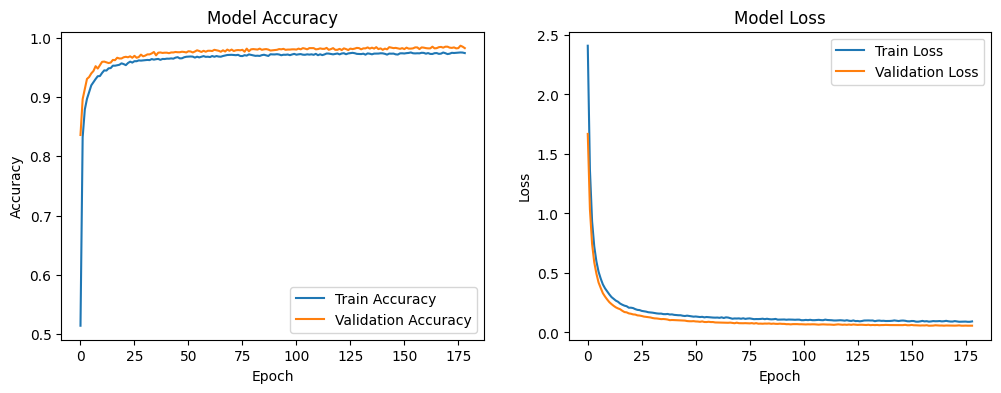

In [9]:
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history['accuracy'], label='Train Accuracy')
plt.plot(history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history['loss'], label='Train Loss')
plt.plot(history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.show()

In [10]:
print(f"Mô hình tốt nhất đã được lưu tại: {os.path.join(model_dir, best_model_filename)}")

Mô hình tốt nhất đã được lưu tại: ../../models/MobileNetV2\mobilenetv2_best_model_v1.pth
